# Intuitions on State Space Model

In this notebook, we will play around with the parameters of a state space model and generate various spike trains.
These population activity patterns will be fun to look at. (hopefully)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## A simple 1-D latent process

For illustration, we will use a sinusoid as the 1-D latent process.
$$ x(t) = sin(2\pi f\cdot t) $$
In this example, $x(t)$ represents the instantaneous state of the neural population of interest.

In [2]:
# simulate a simple latent process
nT = 1000
T = 10
frq = 0.3
tr = np.linspace(0, T, nT)
dt = tr[1] - tr[0]
x = np.sin(2 * np.pi * frq * tr) # generate a sinusoid over time

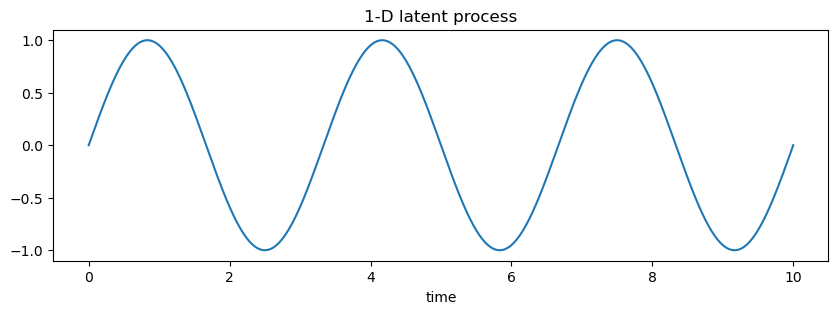

In [3]:
fig = plt.figure(figsize=(10, 3))
plt.plot(tr, x); plt.title('1-D latent process'); plt.xlabel('time');

## One Poisson neuron driven by the latent process

We will generate spike trains from an inhomogeneous Poisson process with a time varying firing rate function $\lambda(t)$.
The spike count $y(t)$ in a small time bin of size $\Delta$ is distributed as a Poisson distribution:
$$ y(t) \sim \text{Poisson}(\Delta\lambda(t)) $$

Importantly, the firing rate will be a function of $x(t)$, but not of past $x$ nor past $y$.
$$ \lambda(t) = g(x(t)) $$
The only constraint is that the firing rate has to be non-negative.
A mathematically convenient function is the exponential function.

$$ \lambda(t) = \exp(a x(t) + b) = \exp(b)\exp(a x(t)) $$

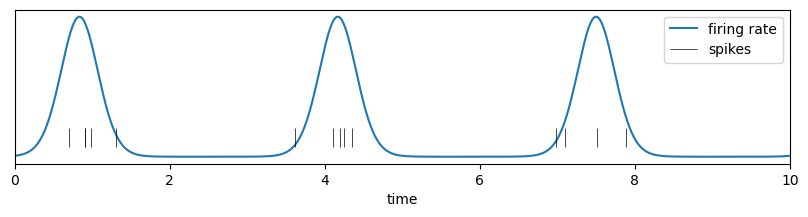

In [4]:
a = 5
b = -3
lam = np.exp(a * x + b)
y = np.random.poisson(lam*dt)

plt.figure(figsize=(10, 2))
plt.plot(tr, lam, label='firing rate');
plt.eventplot(np.nonzero(y)[0]/nT*T, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.legend();

## A population of Poisson neurons driven by a common 1-D latent process

TODO: explain linear dimensionality expansion in the observation model

In [5]:
nNeuron = 200
C = 2 * np.random.randn(nNeuron)
cidx = np.argsort(C)
b = -2.0 + np.random.rand(nNeuron,1)
lam = np.exp(np.outer(C, x) + b)
y = np.random.poisson(lam*dt)

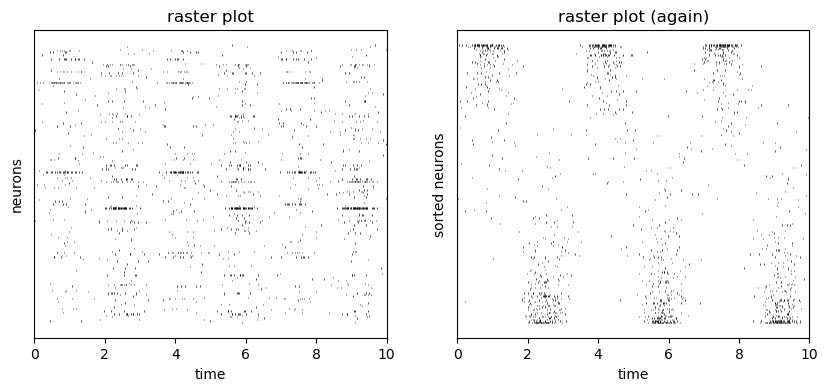

In [6]:
raster = []
rasterSorted = []
for k in range(nNeuron):
    raster.append(np.nonzero(y[k,:])[0]/nT*T)
    rasterSorted.append(np.nonzero(y[cidx[k],:])[0]/nT*T)

plt.subplots(1,2, figsize=(10, 4))
plt.subplot(1,2,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,2,2)
plt.eventplot(rasterSorted, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (again)'); plt.ylabel('sorted neurons');

## 2D latent space example

Here we will build a 2D manifold with two independent processes.
The first latent dimension will be same as above, but we will add $x_2(t)$ as a sawtooth function:
$$ x_2(t) = t \,\, \text{mod} \, 1 $$

In [7]:
x2 = 1.5 * ((tr % 1) - 0.5)
X = np.vstack([x, x2]) # (latent dim) x (time)

Text(0.5, 0, 'time')

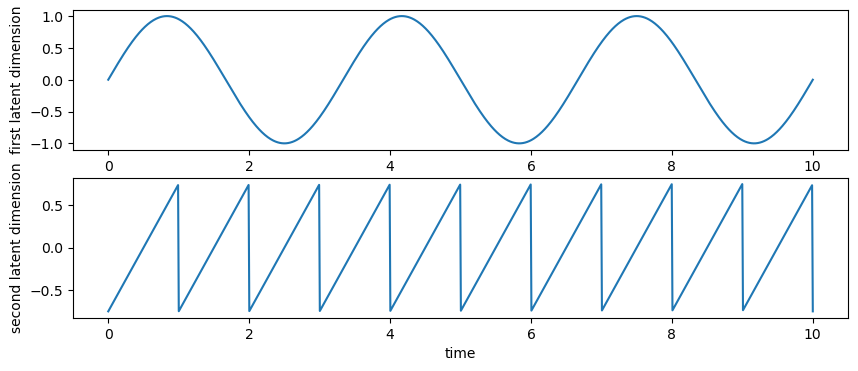

In [8]:
plt.subplots(2,1,figsize=(10,4))
plt.subplot(2,1,1);
plt.plot(tr, x ); plt.ylabel('first latent dimension'); plt.xlabel('time')
plt.subplot(2,1,2);
plt.plot(tr, x2); plt.ylabel('second latent dimension'); plt.xlabel('time')

### Random projection observation

The neural manifold is likely oblique.
[Gao & Ganguli 2015] assumes this.

- Gao, P., & Ganguli, S. (2015). On Simplicity and Complexity in the Brave New World of Large-Scale Neuroscience. Current Opinion in Neurobiology, 32, 148–155.

In [9]:
dLatent = X.shape[0]
C = 2 * np.random.randn(nNeuron, dLatent)
lam = np.exp(C @ X + b)
y = np.random.poisson(lam*dt)

In [10]:
cidx1 = np.lexsort((C[:,0], C[:,1]), axis=0)
cidx2 = np.lexsort((C[:,1], C[:,0]), axis=0)

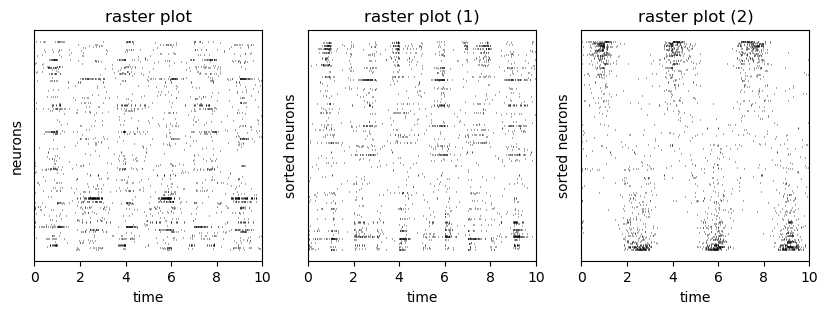

In [11]:
raster = []; rasterSorted1 = []; rasterSorted2 = []
for k in range(nNeuron):
    raster.append(np.nonzero(y[k,:])[0]/nT*T)
    rasterSorted1.append(np.nonzero(y[cidx1[k],:])[0]/nT*T)
    rasterSorted2.append(np.nonzero(y[cidx2[k],:])[0]/nT*T)

plt.subplots(1,3, figsize=(10, 3))
plt.subplot(1,3,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,3,2)
plt.eventplot(rasterSorted1, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (1)'); plt.ylabel('sorted neurons');
plt.subplot(1,3,3)
plt.eventplot(rasterSorted2, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (2)'); plt.ylabel('sorted neurons');

### Axis aligned observation

Biologists have long loved neurons that are tuned specifically for a particular feature but not modulated by others.
In our context, the neurons will be either driven by the first dimension or the second dimension of the latent process.
Recent paper argues that this is optimal [Whittington et al. 2022].

 - Whittington, J. C. R., Dorrell, W., Ganguli, S., & Behrens, T. E. J. (2022). Disentangling with Biological Constraints: A Theory of Functional Cell Types. In arXiv [q-bio.NC]. arXiv. http://arxiv.org/abs/2210.01768

In [12]:
C = 2.0 * np.random.randn(nNeuron, dLatent)
b = -2.0 + np.random.rand(nNeuron,1)
bidx = np.random.rand(nNeuron) < 0.5
C[bidx, 0] = 0
C[~bidx, 1] = 0
b[bidx] += 1.5 # boost the firing rate a bit for the 2nd latent dim
lam = np.exp(C @ X + b)
y = np.random.poisson(lam*dt)

In [13]:
cidx = np.lexsort((C[:,1], C[:,0]), axis=0)

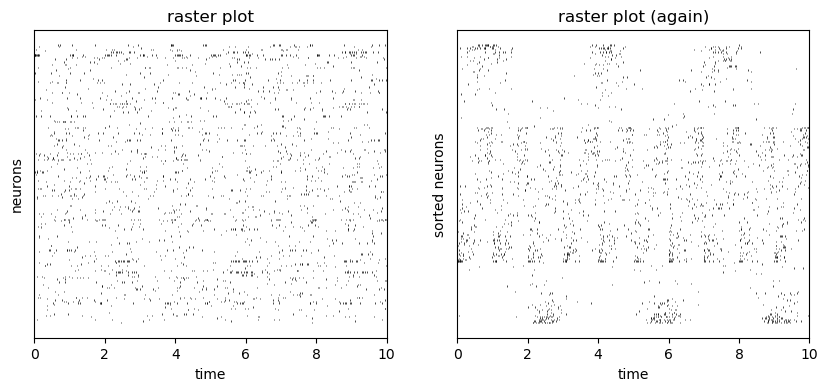

In [14]:
raster = []
rasterSorted = []
for k in range(nNeuron):
    raster.append(np.nonzero(y[k,:])[0]/nT*T)
    rasterSorted.append(np.nonzero(y[cidx[k],:])[0]/nT*T)

plt.subplots(1,2, figsize=(10, 4))
plt.subplot(1,2,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,2,2)
plt.eventplot(rasterSorted, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (again)'); plt.ylabel('sorted neurons');

## Another example: A state space model with 2D dynamics
Van der pol oscillator is defined as follows:
    $ \dot{x} = y$
    $ \dot{y} = \mu(1-x^2)y -x $

For our simulations we consider an Euler discretization of a Van der Pol oscillator with noisy transitions with $\mu=1.5$, $\tau_1=0.1$, $\tau_2=0.1$, and $\sigma=0.1$:

$z_{t+1,1} = z_{t,1} + \tau_1^{-1} \Delta z_{t,2} + \sigma \epsilon$\
$z_{t+1,2} = z_{t,2} + \tau_2^{-1} \Delta(\mu (1-z_{t,1})^2 z_{t,2} - z_{t,1}) + \sigma \epsilon$

and Poisson observations:

$y_{n,t} \sim \text{Poisson}(y_{n,t} \mid \Delta \exp(C_n^\top z_t + b_n))$

For the sake of brevity in the notebook, the generation code is provided in `code_pack/genereate_vdp_data.py` and we only load the saved data here.

In [15]:
import h5py
import scipy
import scipy.ndimage
from einops import rearrange

import matplotlib

from code_pack.plotting import plot_two_d_vector_field_from_data, raster_to_events
from code_pack.generate_vdp_data import generate_van_der_pol, generate_noisy_van_der_pol
from code_pack.utils import best_fit_transformation

# loading data from ./data/vdp_noisy.h5
file_name = "vanderpol/data/poisson_obs.h5"

# dynamics parameters
data = h5py.File(file_name, 'r')
system_parameters = {}
system_parameters['mu'] = data['mu']
system_parameters['tau_1'] = data['tau_1']
system_parameters['tau_2'] = data['tau_2']
system_parameters['sigma'] = data['sigma']
system_parameters['scale'] = np.array(data['scale'])

Y = np.array(data['Y'])
X = np.array(data['X'])
C = np.array(data['C'])
b = np.array(data['bias'])

n_trials = Y.shape[0]
n_latents = X.shape[2]
n_neurons = Y.shape[2]
n_time_bins = Y.shape[1]

### Visualizationing trajectories

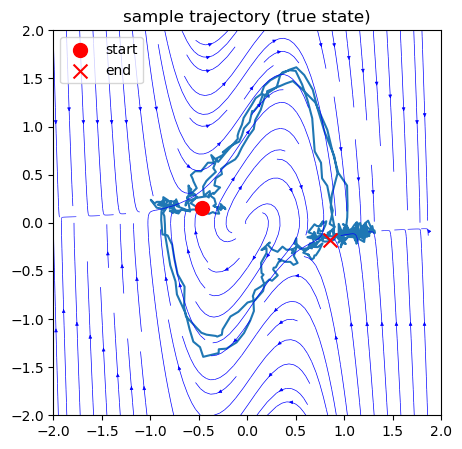

In [16]:
# plotting trajectories of the dataset
fig, ax = plt.subplots(1, 1, figsize=(5,5))
_ = ax.plot(X[0,:,0], X[0,:,1])
ax.scatter(X[0, 0, 0], X[0, 0, 1], marker='o', color='red', zorder=10, s=100, label='start')
ax.scatter(X[0, -1, 0], X[0, -1, 1], marker='x', color='red', zorder=10, s=100, label='end')

# system_parameters_copy = copy.deepcopy(system_parameters)
system_parameters['sigma'] = 0.0
dynamic_func = lambda inp : generate_noisy_van_der_pol(inp, np.array([0.0, 5e-3]), system_parameters)
axs_range = {'x_min':-1.5, 'x_max':1.5, 'y_min':-1.5, 'y_max':1.5}
plot_two_d_vector_field_from_data(dynamic_func, ax, axs_range)

ax.legend()
ax.set_title('sample trajectory (true state)');

### Effect of tuning function

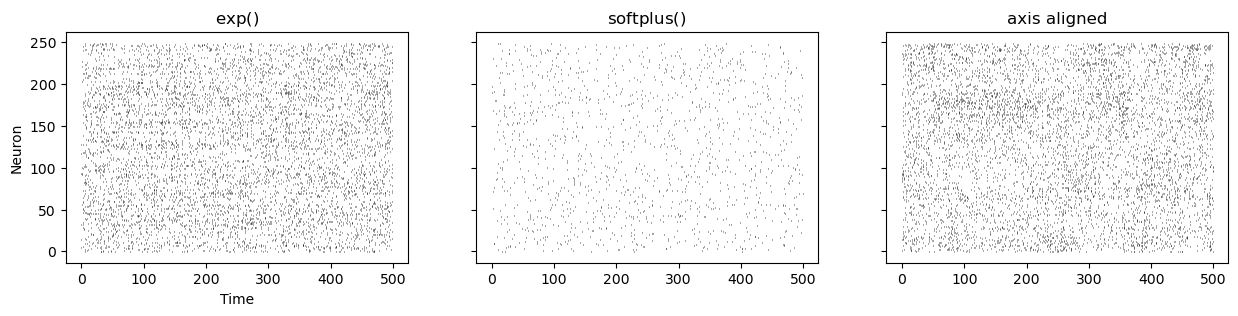

In [37]:
C_tilde = np.array(data['C_tilde'])
idx = np.lexsort((C_tilde[:, 0], C_tilde[:, 1]), axis=0)  # sort the loading

# showing the spike raster generated from noisy Vdp
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)
events = raster_to_events(np.array(data['Y'])[0, :, :])
events_softplus = raster_to_events(np.array(data['Y_softplus'])[0, :, :])
events_axis_aligned = raster_to_events(np.array(data['Y_axis'])[0, :, idx].transpose())
axs[0].eventplot(events, linewidths=0.5, color='k');
axs[1].eventplot(events_softplus, linewidths=0.5, color='k');
axs[2].eventplot(events_axis_aligned, linewidths=0.5, color='k');
axs[0].set_title(f'$\exp()$');
axs[1].set_title(f'softplus$()$');
axs[2].set_title(f'axis aligned');
axs[0].set_xlabel("Time");
axs[0].set_ylabel("Neuron");

### PCA

In [18]:
# smoothing data with a gaussian kernel
data_stacked = rearrange(np.array(data['Y']), 'trial time neurons -> (trial neurons) time')
data_smooth = scipy.ndimage.gaussian_filter1d(input = data_stacked, sigma=50.0, axis=1)
data_smooth = rearrange(data_smooth, '(trial neurons) time -> (trial time) neurons', trial=250, neurons=250) # TODO: hardcoded
data_centered = data_smooth - np.mean(data_smooth, axis=0)

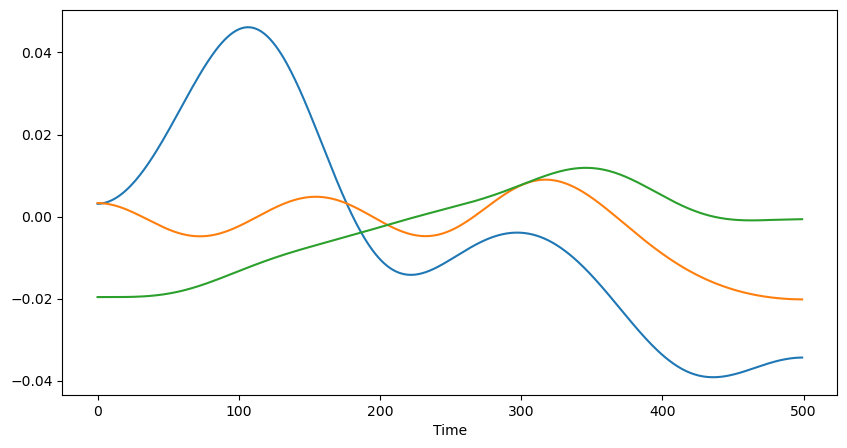

In [19]:
tidx = slice(500,1000)
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
ax.plot(data_centered[tidx, 0:3]);
ax.set_xlabel("Time");

In [20]:
# PCA using SVD
u, s, vh = np.linalg.svd(data_centered, full_matrices=False)
u.shape, s.shape

((125000, 250), (250,))

In [21]:
norm_sv = s**2/np.sum(s**2)
top2sv = np.sum(norm_sv[:2])
print("Total observations explained by the first two principal components: {0:.3f}%".format(top2sv*100))

Total observations explained by the first two principal components: 22.745%


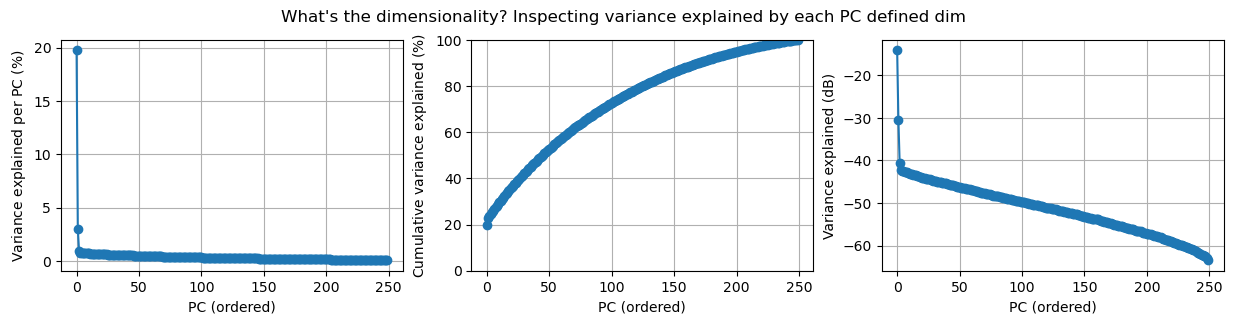

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].plot(norm_sv * 100, 'o-')
axs[1].plot(norm_sv.cumsum() * 100, 'o-')
axs[1].set_ylim([0, 100])
axs[2].plot(20*np.log10(norm_sv), 'o-')

[(axs[k].grid(), axs[k].set_title(f'')) for k in range(3)]
axs[0].set_ylabel("Variance explained per PC ($\%$)");
axs[1].set_ylabel("Cumulative variance explained ($\%$)");
axs[2].set_ylabel("Variance explained (dB)");
axs[0].set_xlabel("PC (ordered)");
axs[1].set_xlabel("PC (ordered)");
axs[2].set_xlabel("PC (ordered)");
fig.suptitle("What's the dimensionality? Inspecting variance explained by each PC defined dim");

(125000, 2)


Text(0.5, 0, 'Time')

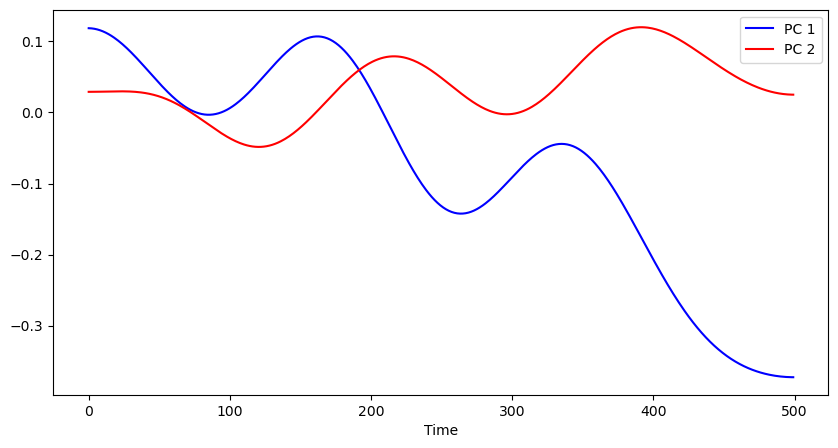

In [23]:
# visualizing top two PCs
top2u = u[:, :2]
top2s = s[:2]
top2reconstruction = top2u * top2s
print(top2reconstruction.shape)
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
ax.plot(top2reconstruction[tidx, 0], color='blue', label='PC 1')
ax.plot(top2reconstruction[tidx, 1], color='red', label='PC 2')
ax.legend()
ax.set_xlabel("Time")

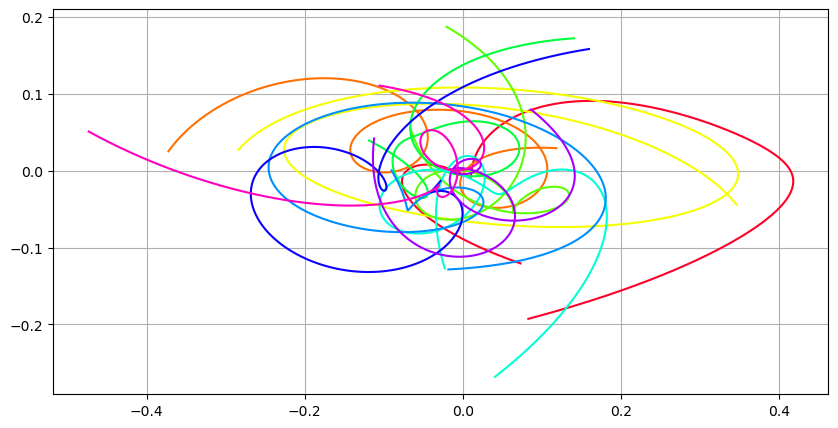

In [24]:
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
nTrial = 10
cmap = matplotlib.colormaps['gist_rainbow'].resampled(nTrial)
for trial in range(nTrial):
    tidx = slice(500*trial, 500*(trial+1))
    ax.plot(top2reconstruction[tidx, 0], top2reconstruction[tidx, 1], color=cmap(trial))
ax.grid()

### Correcting for invariance in the principal components to show closest orientation to true latents

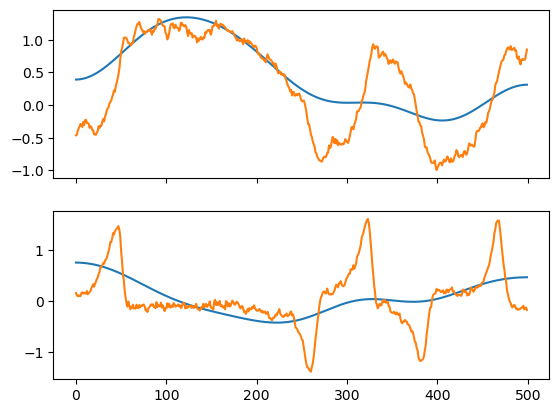

In [26]:
X_hat_tilde = best_fit_transformation(rearrange(X, 'trials time lat -> (trials time) lat'), top2reconstruction, n_trials, n_time_bins, n_latents)

fig, axs = plt.subplots(2, 1, sharex='all')
axs[0].plot(X_hat_tilde[0, :, 0])
axs[0].plot(X[0, :, 0])
axs[1].plot(X_hat_tilde[0, :, 1])
axs[1].plot(X[0, :, 1])
plt.show()

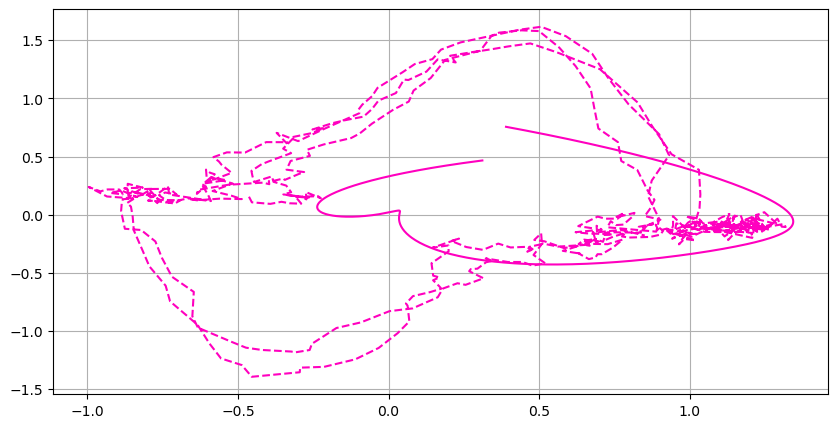

In [34]:
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
nTrial = 1
cmap = matplotlib.colormaps['gist_rainbow'].resampled(nTrial)

for trial in range(nTrial):
    ax.plot(X_hat_tilde[trial, :, 0], X_hat_tilde[trial, :, 1], color=cmap(trial))
    ax.plot(X[trial, :, 0], X[trial, :, 1], '--', color=cmap(trial))
ax.grid()

## What's next?

Now we understand better the generative process of the model. But what we are interested is the opposite direction, that is, how do we infer the model parameters given just the observations (neural data)? This is the statistical inference problem of interest.